In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from seaborn import set_style
import statsmodels.tsa.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
set_style("whitegrid")

In [3]:
stock_symbols = ['GOOG','MSFT','AMZN','NVDA','AAPL']

In [5]:
df = [pd.read_csv(f'/home/hirak/Desktop/Erdos/SIGNS_2024/stock_data/{symbol}/stock_price.csv') for symbol in stock_symbols]
df_ss = [pd.read_csv(f'/home/hirak/Desktop/Erdos/SIGNS_2024/stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_{symbol}.csv') for symbol in stock_symbols]

In [6]:
len(df), len(df_ss)

(5, 5)

In [7]:
for i in range(len(df)):
    df[i]['Date'] = pd.to_datetime(df[i]['Date'], utc=True).dt.date
    # df[i]['Date'].index = pd.DatetimeIndex(df[i]['Date'].index).to_period('M')
    df_ss[i]['Date'] = pd.to_datetime(df_ss[i]['Date'], utc=True).dt.date
    # df_ss[i]['Date'].index = pd.DatetimeIndex(df_ss[i]['Date'].index).to_period('M')
    # df_gss[i]['Date'] = pd.to_datetime(df_gss[i]['Date'], utc=True).dt.date
    # print(len(df[i]), len(df_ss[i]), len(df_gss[i]))

In [8]:
df = [df[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
df_ss = [df_ss[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
# df_gss = [df_gss[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
for i in range(len(df)):
    print(len(df[i]), len(df_ss[i]))

3457 1663
3457 1626
3457 1979
3457 1486
3457 1997


In [9]:
# Merge on the 'date' column, only take common days from both dataframes
df = [pd.merge(df[i], df_ss[i], on='Date', how='outer') for i in range(len(df))]  # 'how' can be 'inner', 'outer', 'left', or 'right'
df = [df[i].drop(['Ticker'],axis=1) for i in range(len(df))]
for i in range(len(df)):
    print(len(df[i]))

3789
3744
3913
3741
3892


In [10]:
df = [df[i].dropna(subset=['Open']) for i in range(len(df))]
df = [df[i].fillna(0.0) for i in range(len(df))]

In [11]:
for i in range(len(df)):
    print(len(df[i]))

3457
3457
3457
3457
3457


In [12]:
df[0].head(-5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,weighted positive sentiment score,weighted negative sentiment score,weighted neutral sentiment score,weighted compound sentiment score
0,2011-01-03,14.819920,15.046263,14.819920,15.015455,94962614.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2011-01-04,15.047010,15.060922,14.910357,14.960049,73253547.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,2011-01-05,14.909116,15.164031,14.908619,15.132727,101671667.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,2011-01-06,15.172727,15.365282,15.157075,15.242792,82620526.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,2011-01-07,15.302670,15.360810,15.159063,15.315838,84363033.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3737,2024-09-16,158.330002,159.240005,157.610001,158.990005,14157600.0,0.0,0.0,0.368930,0.304656,0.760461,0.206810
3738,2024-09-17,160.089996,161.589996,159.410004,160.279999,12064800.0,0.0,0.0,0.319693,0.149000,0.879976,0.476711
3739,2024-09-18,160.850006,161.630005,159.660004,160.809998,16756500.0,0.0,0.0,0.339090,0.305160,0.759004,0.414720
3740,2024-09-19,164.820007,164.990005,162.522003,163.240005,17548200.0,0.0,0.0,0.254319,0.204681,0.865323,0.148532


In [13]:
df_close = [df[i][["Close"]].copy() for i in range(len(df))]

In [14]:
df_close_sma = [df_close[i].rolling(window=14).mean() for i in range(len(df))]

In [15]:
df_sma_ss = [df[i][["weighted compound sentiment score"]].copy() for i in range(len(df))]

In [16]:
df_close = [df_close[i][14:] for i in range(len(df))]
df_close = [df_close[i].reset_index() for i in range(len(df))]
df_close_sma = [df_close_sma[i][14:] for i in range(len(df))]
df_close_sma = [df_close_sma[i].reset_index() for i in range(len(df))]
df_sma_ss = [df_sma_ss[i][14:] for i in range(len(df))]
df_sma_ss = [df_sma_ss[i].reset_index() for i in range(len(df))]

In [17]:
df_close = [df_close[i].drop(['index'],axis=1) for i in range(len(df_close))]
df_close_sma = [df_close_sma[i].drop(['index'],axis=1) for i in range(len(df_close_sma))]
df_sma_ss = [df_sma_ss[i].drop(['index'],axis=1) for i in range(len(df_sma_ss))]

In [18]:
df_close[0].head(-5)

,Close
0,15.182666
1,15.402054
2,15.317329
3,15.324534
4,14.931973
...,...
3433,158.990005
3434,160.279999
3435,160.809998
3436,163.240005


In [49]:
df_close_sma[0]

,Close
0,15.351314
1,15.382886
2,15.396072
3,15.401911
4,15.374492
...,...
3438,157.468860
3439,157.900107
3440,158.228571
3441,159.078571


In [50]:
df_sma_ss[0]

,weighted compound sentiment score
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
3438,0.442796
3439,0.434495
3440,-0.162535
3441,-0.158908


In [51]:
for i in range(len(df_close_sma)):
    result = adfuller(df_close_sma[i].Close)
    print(f'ADF statistic: {result[0]}')
    print(f'p-value: {result[1]}')

ADF statistic: 0.2488004604477506
p-value: 0.9748696156176361
ADF statistic: 1.462930240860932
p-value: 0.9973820860273647
ADF statistic: -0.21707129209394604
p-value: 0.9364559368381958
ADF statistic: 4.867917664692226
p-value: 1.0
ADF statistic: 0.9608229048652772
p-value: 0.9938348937564851


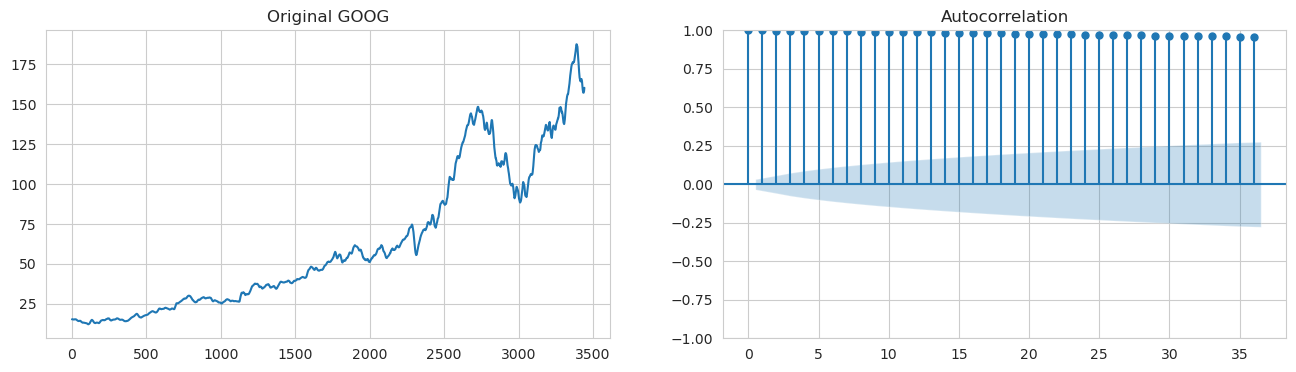

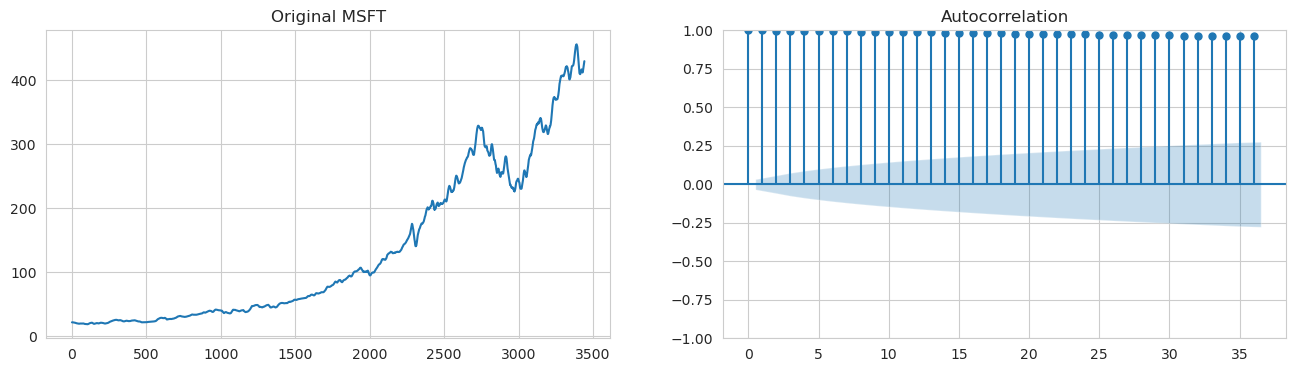

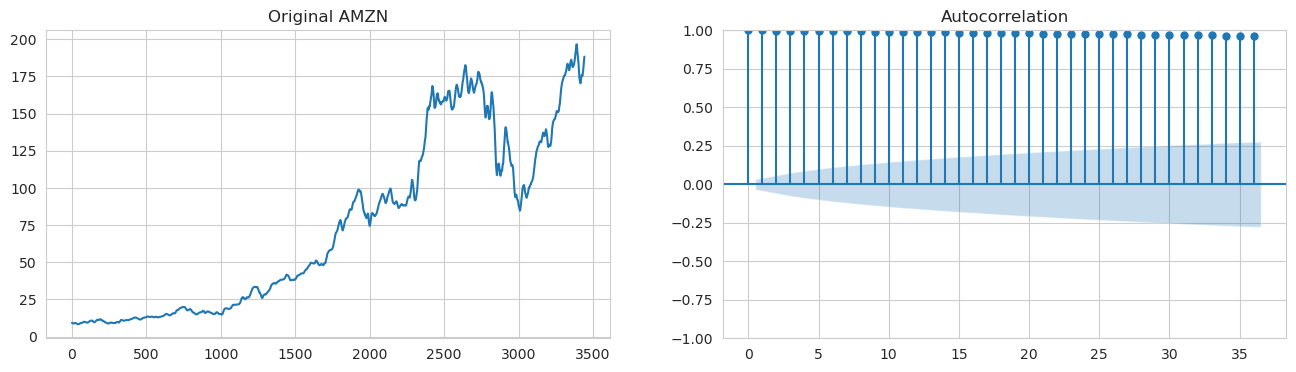

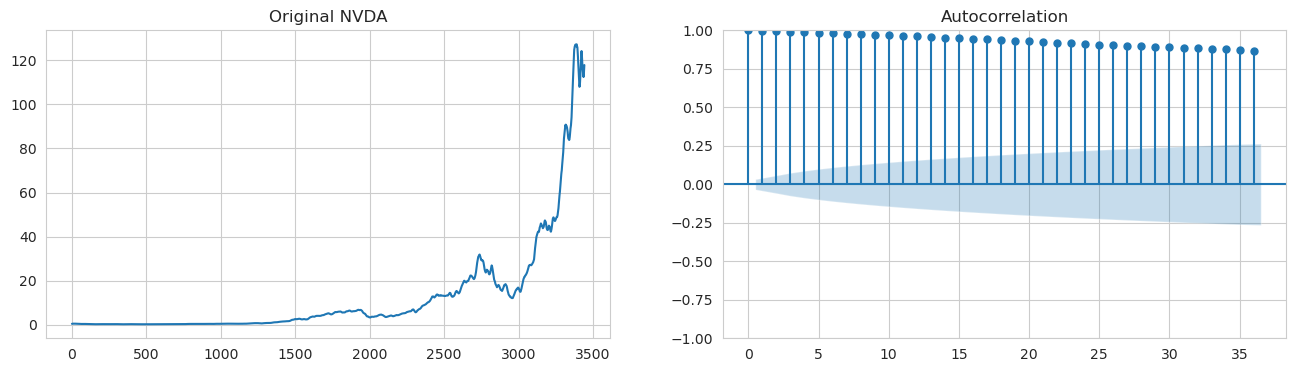

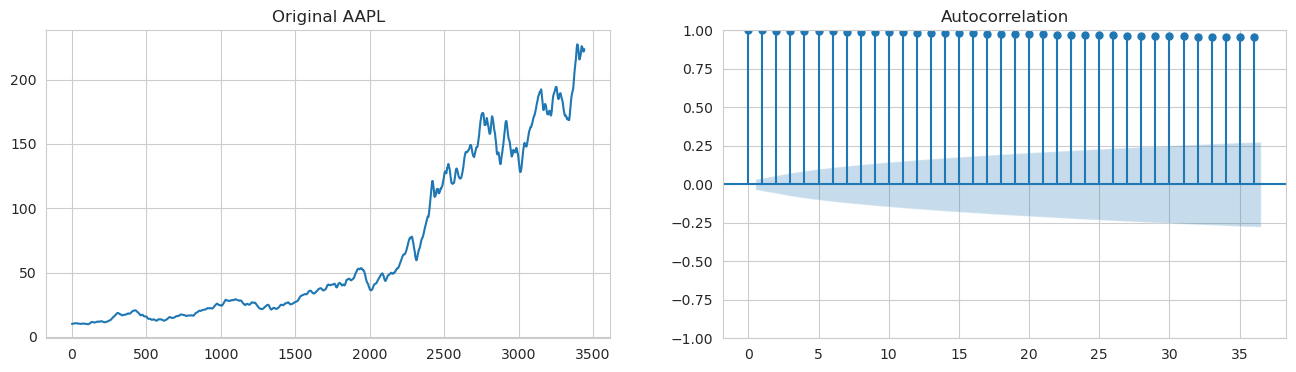

In [52]:
for i in range(len(df_close_sma)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(df_close_sma[i])
    ax1.set_title(f"Original {stock_symbols[i]}")
    plot_acf(df_close_sma[i], ax=ax2);

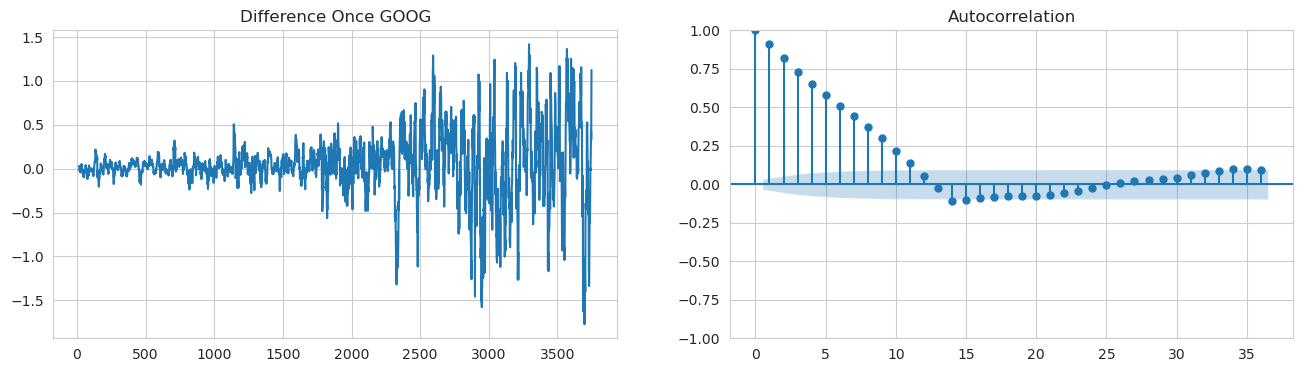

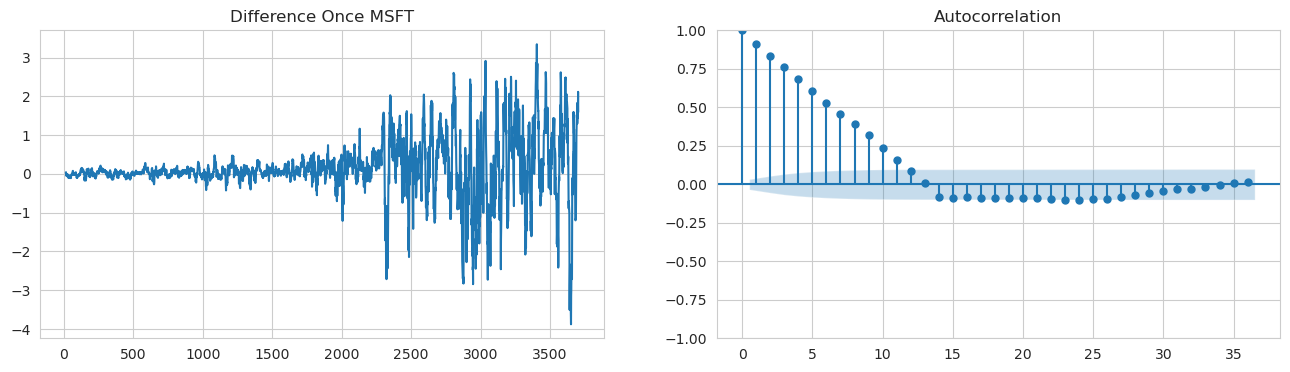

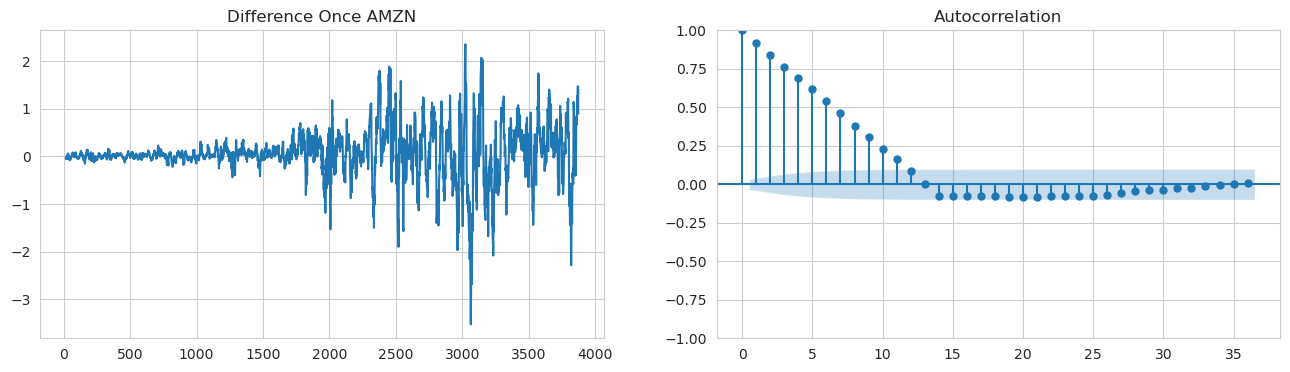

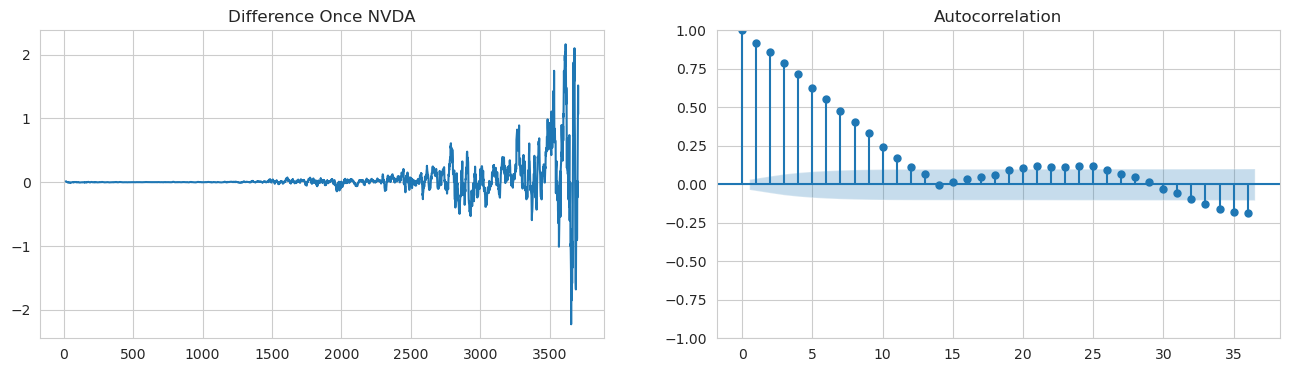

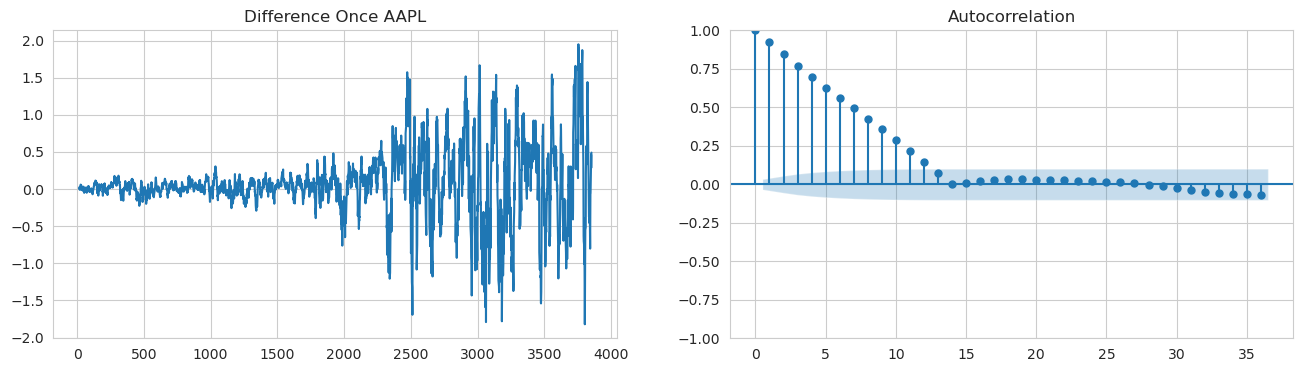

In [20]:
for i in range(len(df_close_sma)):
    diff1 = df_close_sma[i].Close.diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Difference Once {stock_symbols[i]}")
    plot_acf(diff1, ax=ax2);

In [21]:
ndif = [ndiffs(df_close_sma[i], test="adf") for i in range(len(df_close_sma))]
print("ndif", ndif)

ndif [1, 1, 1, 1, 1]


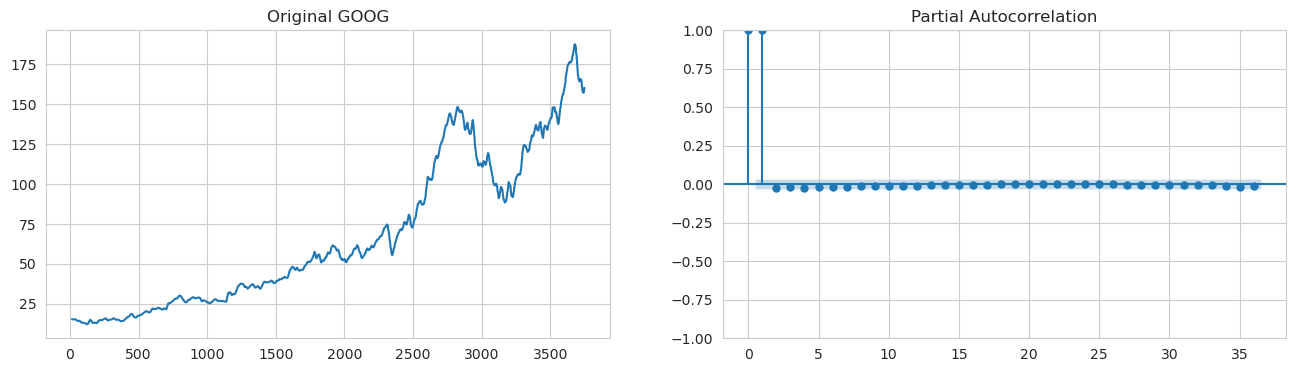

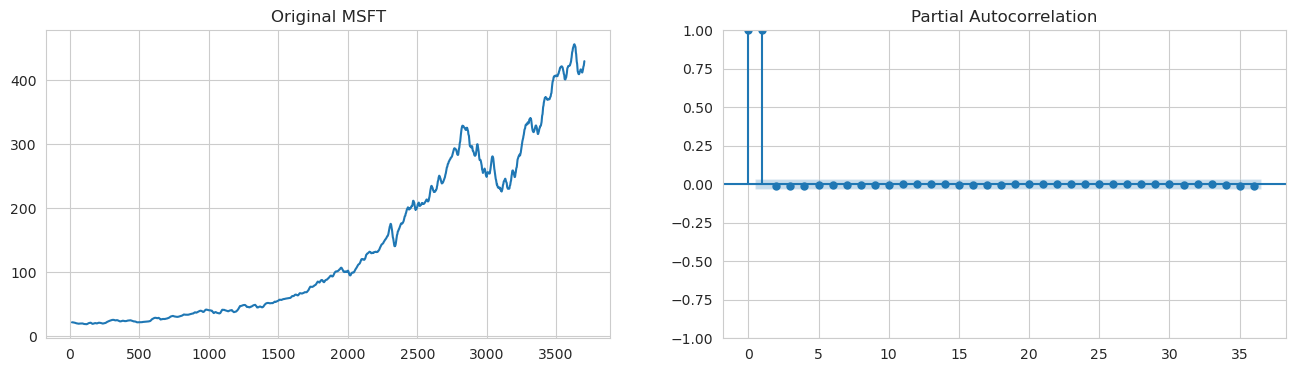

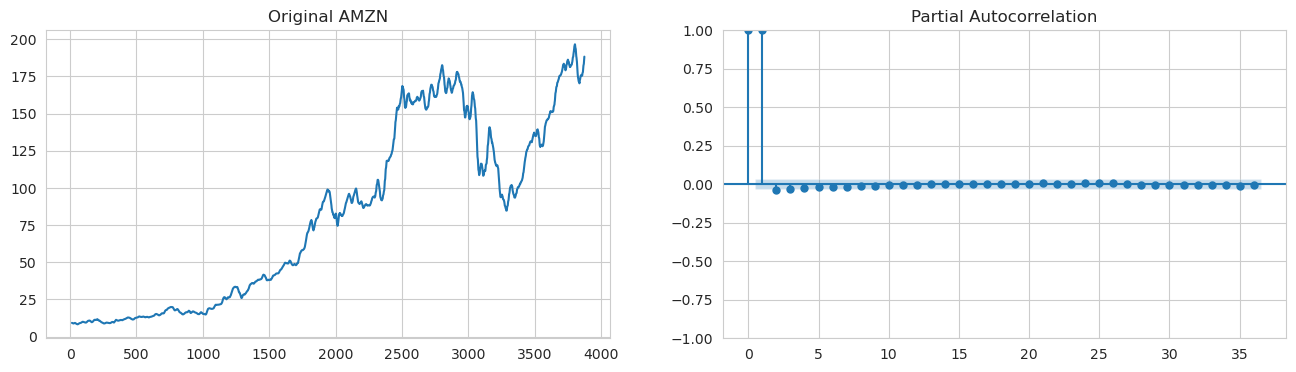

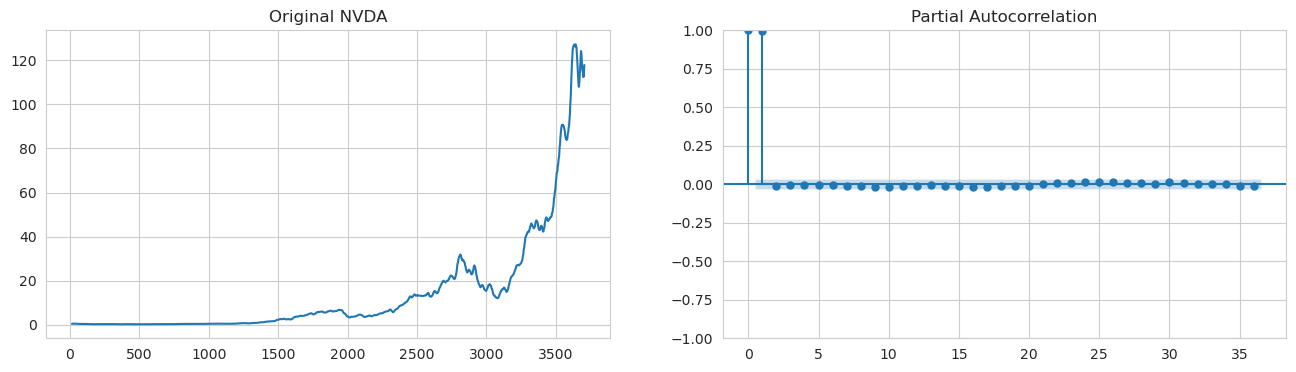

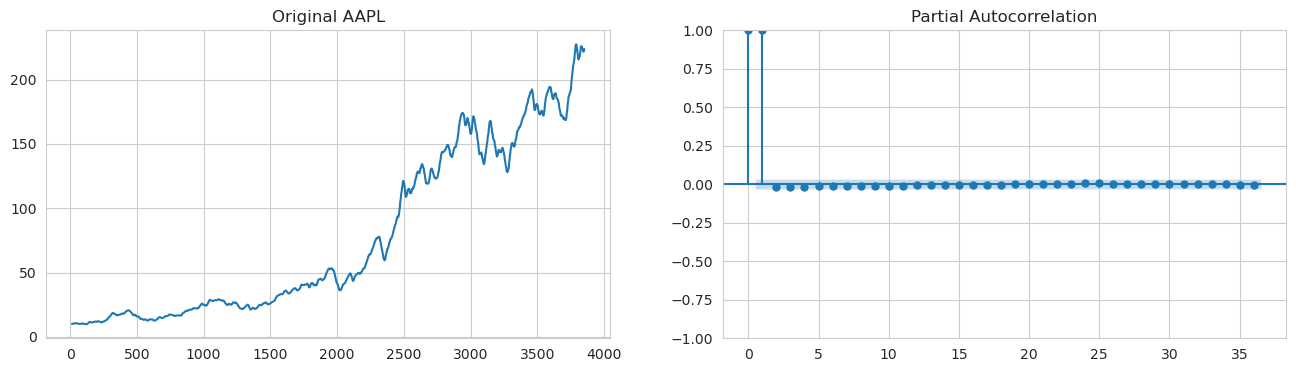

In [22]:
for i in range(len(df_close_sma)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(df_close_sma[i].Close)
    ax1.set_title(f"Original {stock_symbols[i]}")
    plot_pacf(df_close_sma[i].Close, ax=ax2);

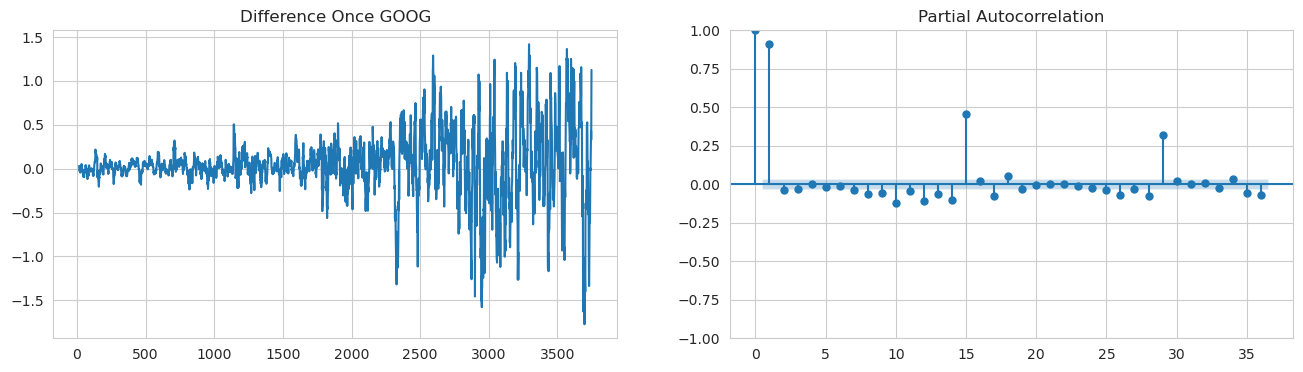

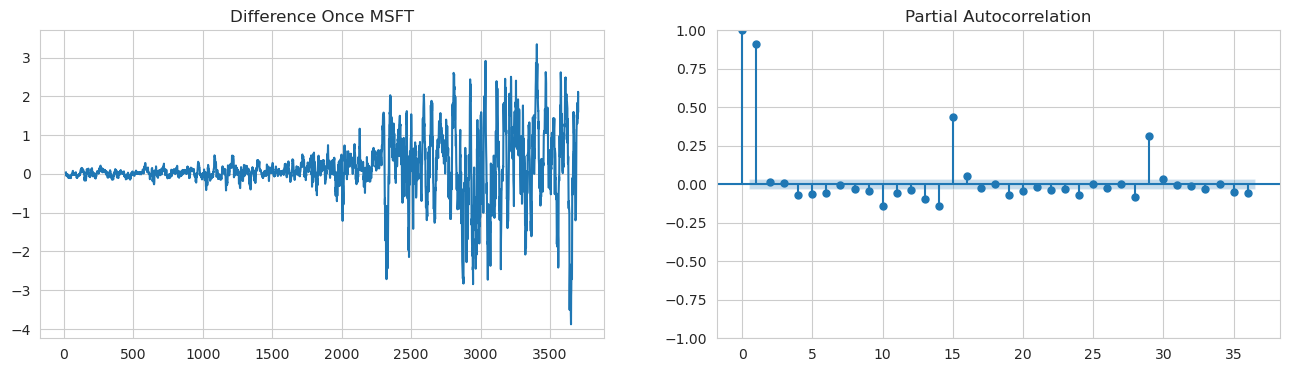

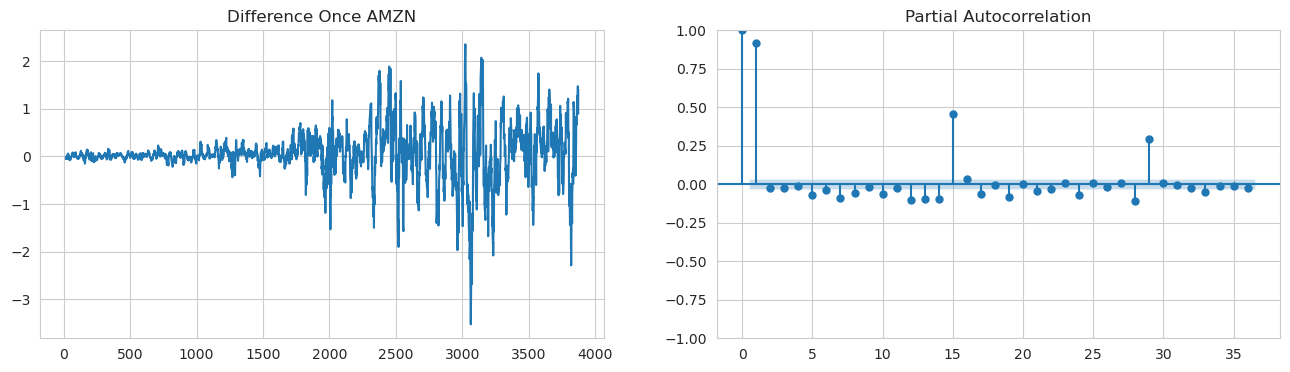

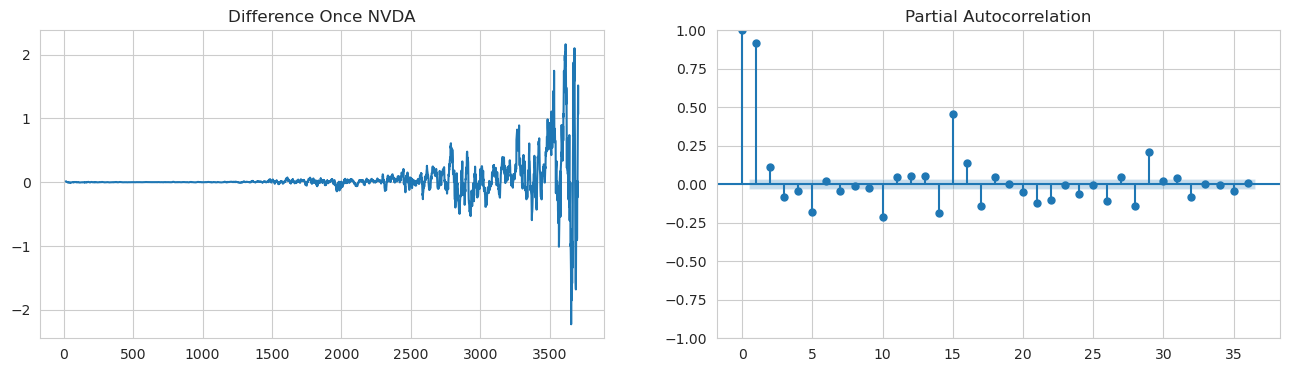

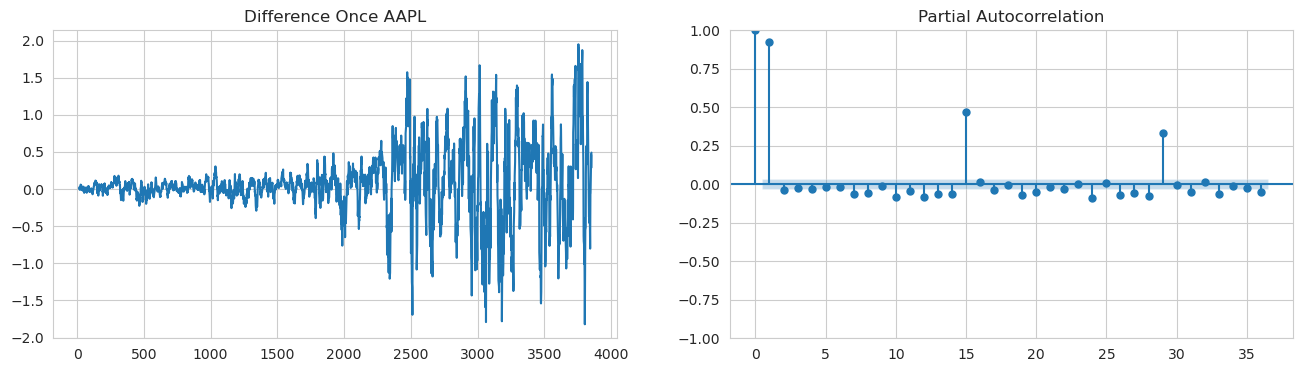

In [23]:
for i in range(len(df_close_sma)):
    diff1 = df_close_sma[i].Close.diff().dropna()

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Difference Once {stock_symbols[i]}")
    plot_pacf(diff1, ax=ax2);

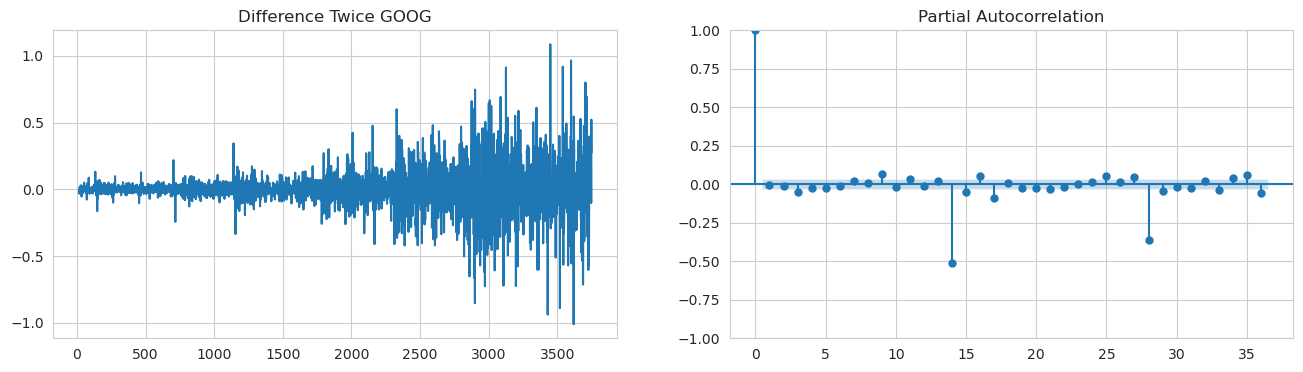

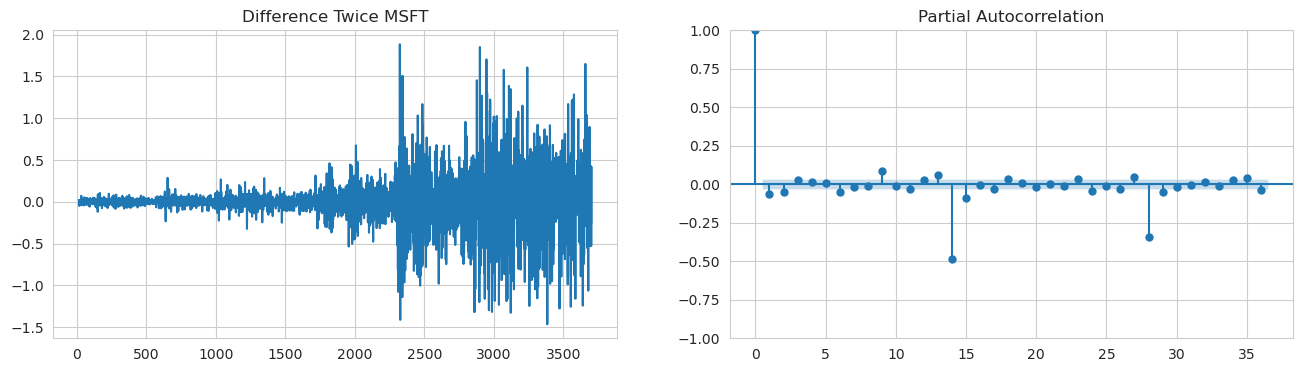

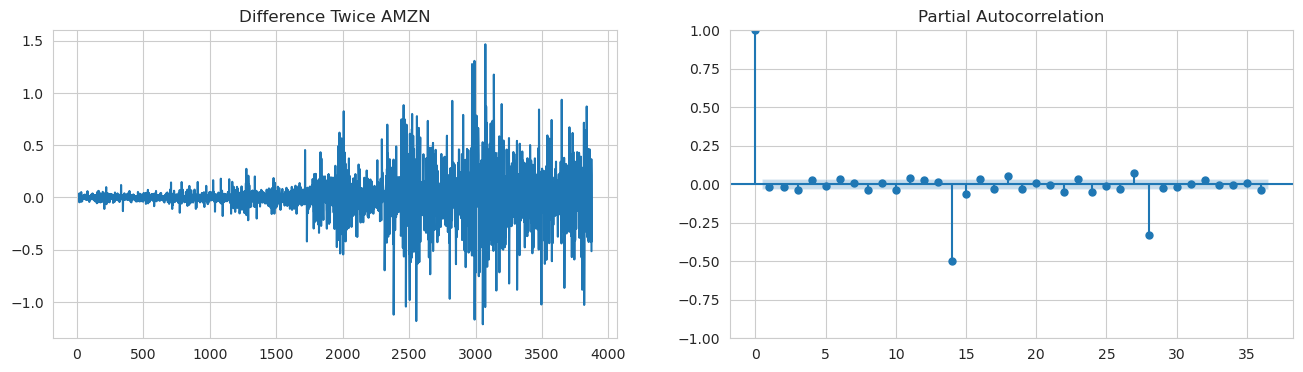

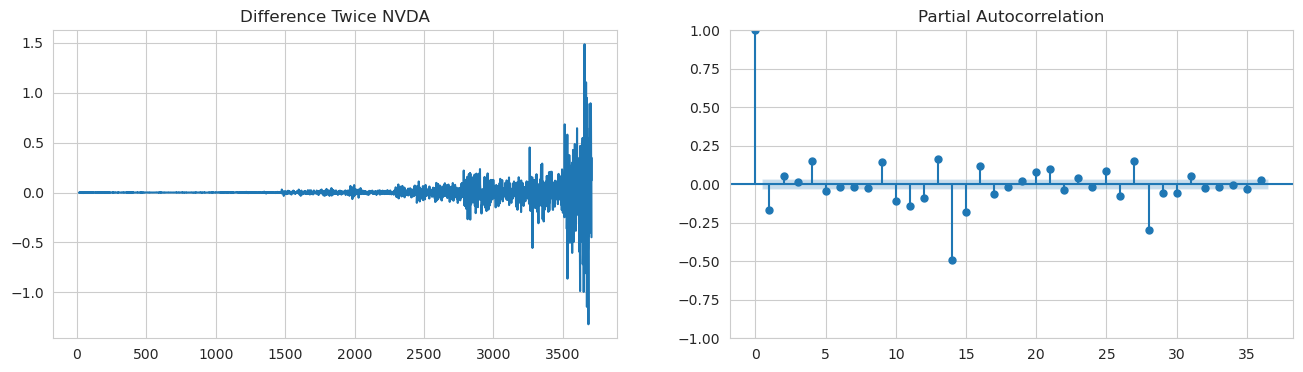

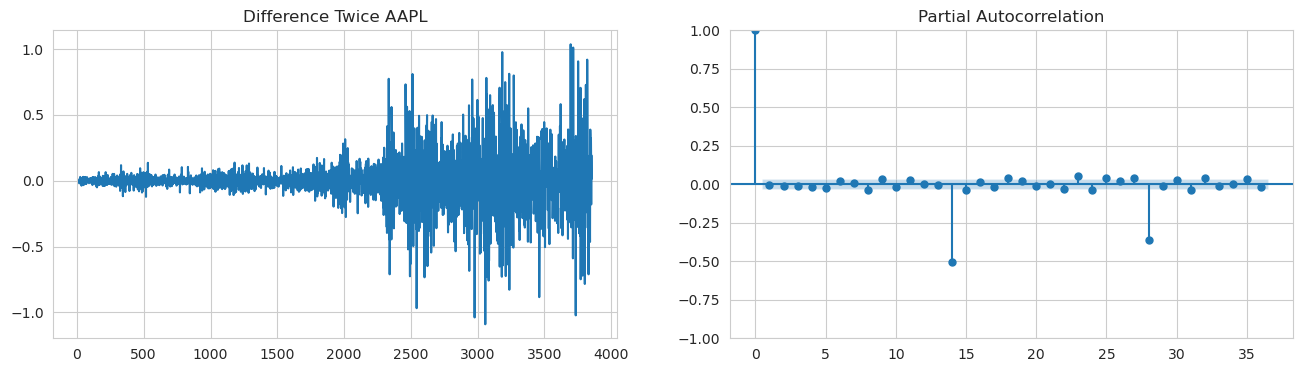

In [24]:
for i in range(len(df_close_sma)):
    diff2 = df_close_sma[i].Close.diff().diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff2)
    ax1.set_title(f"Difference Twice {stock_symbols[i]}")
    plot_pacf(diff2, ax=ax2);

In [71]:
# orderr = auto_arima(df[0].Close, trace=True).get_params().get("order")
# print(orderr)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12156.413, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12154.912, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12154.797, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12157.727, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12156.168, Time=2.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12155.779, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12150.697, Time=2.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12150.076, Time=2.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12149.251, Time=0.81 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=12151.027, Time=0.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=12149.240, Time=5.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=12151.053, Time=5.92 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=12151.368, Time=4.06 sec
 ARIMA(0,1,5)(0,0,0)[0] i

In [55]:
arima_order = {}
for i in range(len(df_close_sma)):
    print(f"Stock name: {stock_symbols[i]}")
    arima_order[i] = auto_arima(df_close_sma[i].Close, trace=True).get_params().get("order")
    print(f"ARIMA Order for {stock_symbols[i]}: {arima_order[i]}")

Stock name: GOOG
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3767.204, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.281, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3761.564, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-641.382, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2336.530, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3769.184, Time=1.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2076.292, Time=2.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3765.523, Time=0.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3767.210, Time=6.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2775.371, Time=2.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3790.992, Time=2.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3766.048, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3767.470, Time=3.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3769.321, Time=0.61 sec
 ARIM

In [56]:
arima_result = {}
for i in range(len(df_close_sma)):
    model = sm.ARIMA(df_close_sma[i].Close, order=arima_order[i])
    arima_result[i] = model.fit()
    print(f"\n ARIMA Results for {stock_symbols[i]}:\n {arima_result[i].summary()}")


 ARIMA Results for GOOG:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3443
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1898.859
Date:                Sun, 17 Nov 2024   AIC                          -3789.718
Time:                        22:06:12   BIC                          -3765.142
Sample:                             0   HQIC                         -3780.940
                               - 3443                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8199      0.022     84.002      0.000       1.777       1.862
ar.L2         -0.8362      0.019    -43.474      0.000      -0.874      -0.799
ma.L1         -0.8713    

/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 ARIMA Results for NVDA:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3443
Model:                 ARIMA(5, 2, 1)   Log Likelihood                3199.367
Date:                Sun, 17 Nov 2024   AIC                          -6384.734
Time:                        22:06:19   BIC                          -6341.730
Sample:                             0   HQIC                         -6369.373
                               - 3443                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8151      0.006    142.890      0.000       0.804       0.826
ar.L2          0.1928      0.006     33.727      0.000       0.182       0.204
ar.L3         -0.0152    

In [76]:
# result.forecast(10)
# residuals = pd.DataFrame(result.resid)

In [78]:
# fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
# ax1.plot(pd.DataFrame(result.resid))
# ax2.hist(pd.DataFrame(result.resid), density=True)


 ARIMA Residuals for GOOG:


 ARIMA Residuals for MSFT:


 ARIMA Residuals for AMZN:


 ARIMA Residuals for NVDA:


 ARIMA Residuals for AAPL:



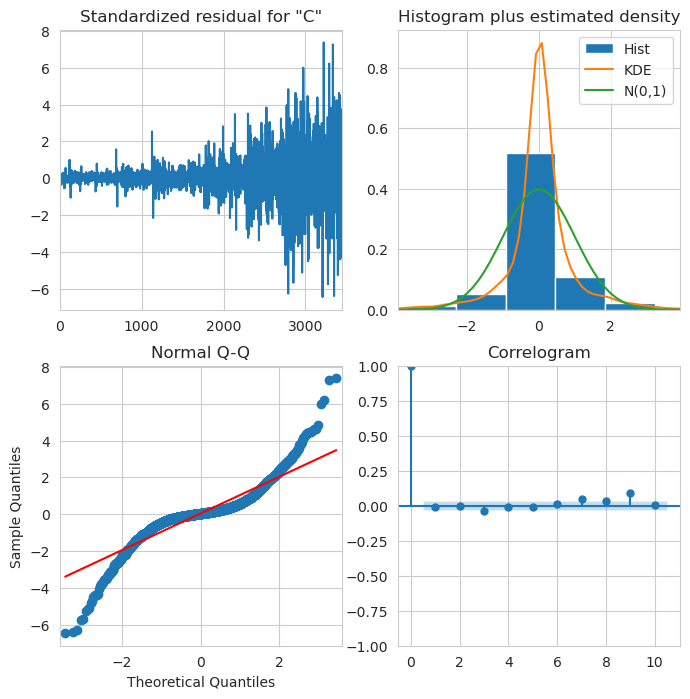

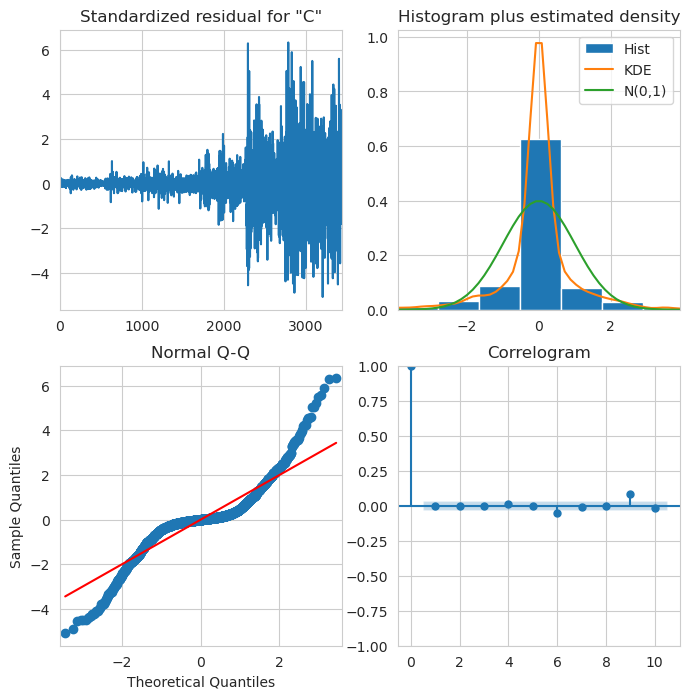

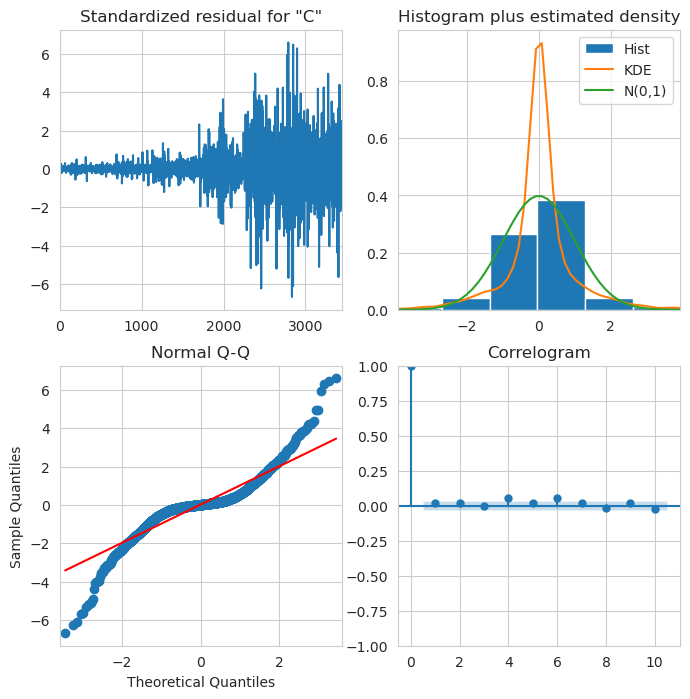

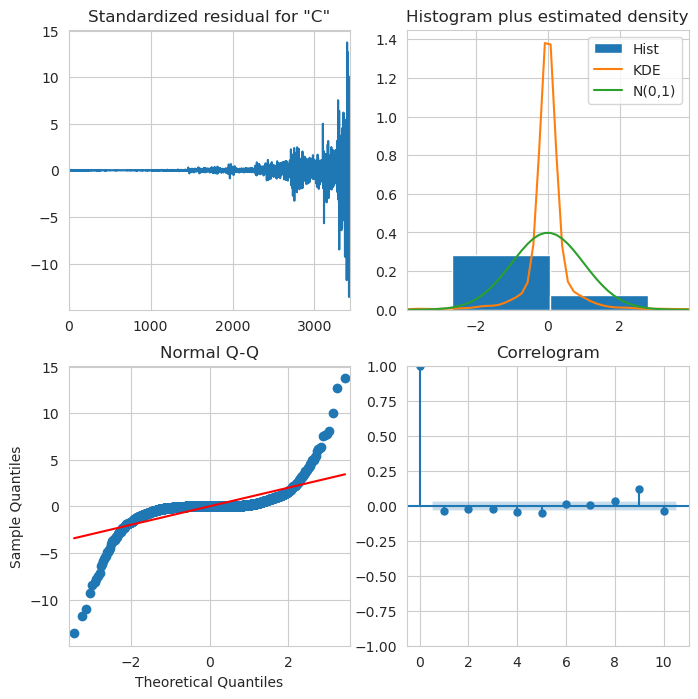

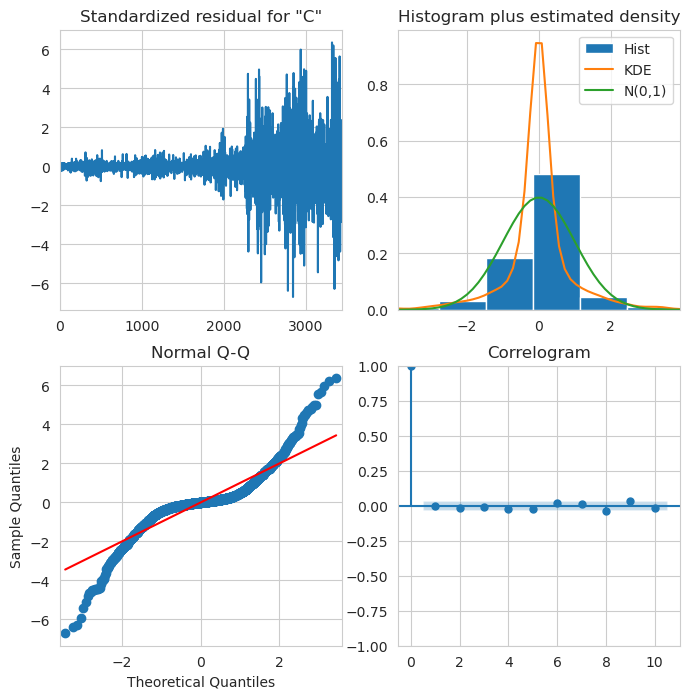

In [57]:
for i in range(len(df_close_sma)):
    arima_result[i].plot_diagnostics(figsize = (8,8))
    print(f"\n ARIMA Residuals for {stock_symbols[i]}:\n")



 Last 100 days stock Closing price for GOOG


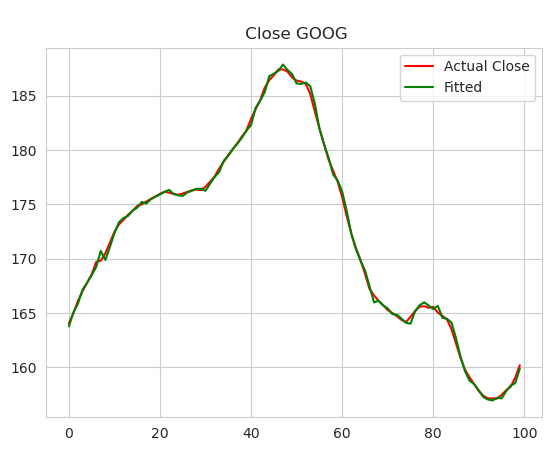


 Last 100 days stock Closing price for MSFT


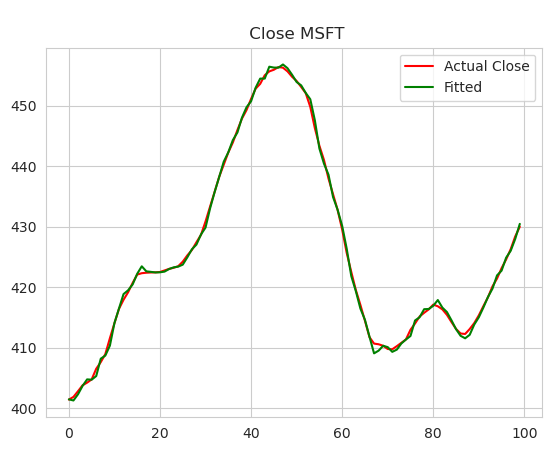


 Last 100 days stock Closing price for AMZN


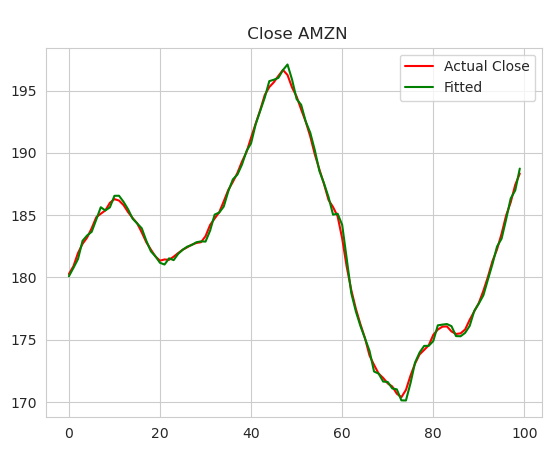


 Last 100 days stock Closing price for NVDA


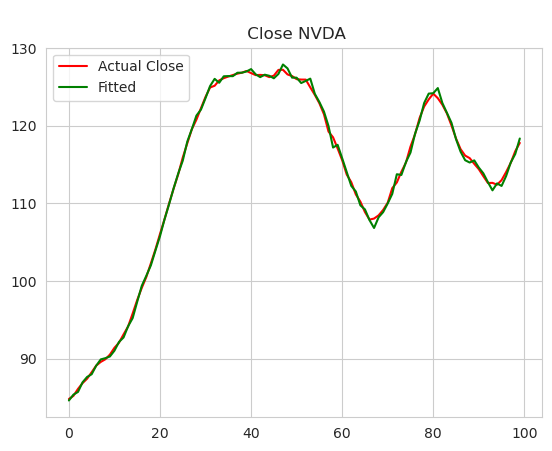


 Last 100 days stock Closing price for AAPL


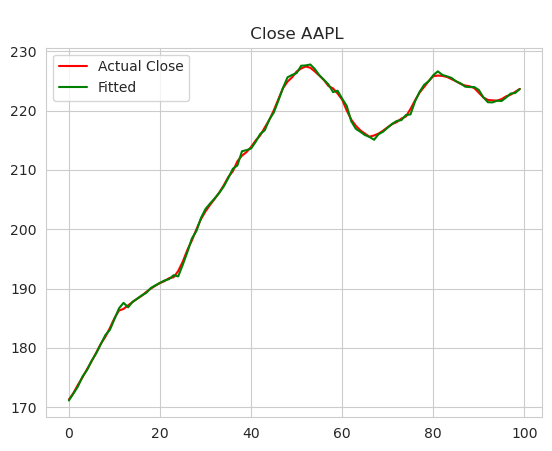

In [58]:
for i in range(len(df_close_sma)):
    print(f"\n Last 100 days stock Closing price for {stock_symbols[i]}")
    plt.plot(range(100), df_close_sma[i].Close[(len(df_close_sma[i])-100):], color='r', label='Actual Close')
    plt.plot(range(100), arima_result[i].fittedvalues[(len(df_close_sma[i])-100):], color='g', label='Fitted')
    plt.legend()
    plt.title(f"\n Close {stock_symbols[i]}")
    plt.show()

In [19]:
train = {}
test = {}
train_ss = {}
test_ss = {}
for i in range(len(df_close_sma)):
    n = 0
    n = int(len(df_close_sma[i])*0.95)
    train[i] = df_close_sma[i][:n]
    test[i] = df_close_sma[i][n:]
    print("sma",len(train[i]), len(test[i]))
for i in range(len(df_sma_ss)):
    n = 0
    n = int(len(df_sma_ss[i])*0.95)
    train_ss[i] = df_sma_ss[i][:n]
    test_ss[i] = df_sma_ss[i][n:]
    print("ss",len(train_ss[i]), len(test_ss[i]))

sma 3270 173
sma 3270 173
sma 3270 173
sma 3270 173
sma 3270 173
ss 3270 173
ss 3270 173
ss 3270 173
ss 3270 173
ss 3270 173


In [20]:
for i in range(len(df_close_sma)):
    result = adfuller(train[i].Close.dropna())
    print(f"For {stock_symbols[i]}")
    print(f'ADF statistic: {result[0]}')
    print(f'p-value: {result[1]}')

For GOOG
ADF statistic: 0.42072283483248085
p-value: 0.9822535768095777
For MSFT
ADF statistic: 1.7050298993146094
p-value: 0.9981408259427789
For AMZN
ADF statistic: -0.5687811612835565
p-value: 0.877881333008081
For NVDA
ADF statistic: 3.2937338279716997
p-value: 1.0
For AAPL
ADF statistic: 0.8535144942900784
p-value: 0.9924526787048981


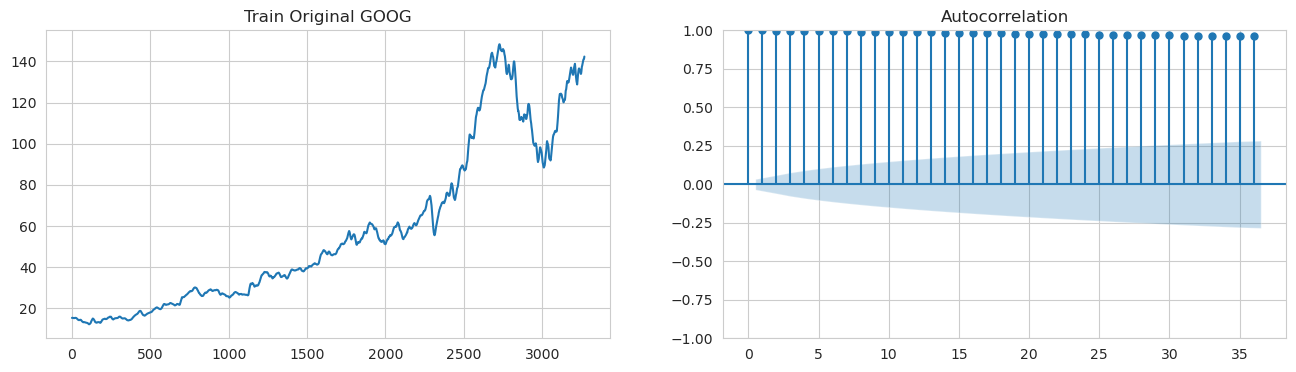

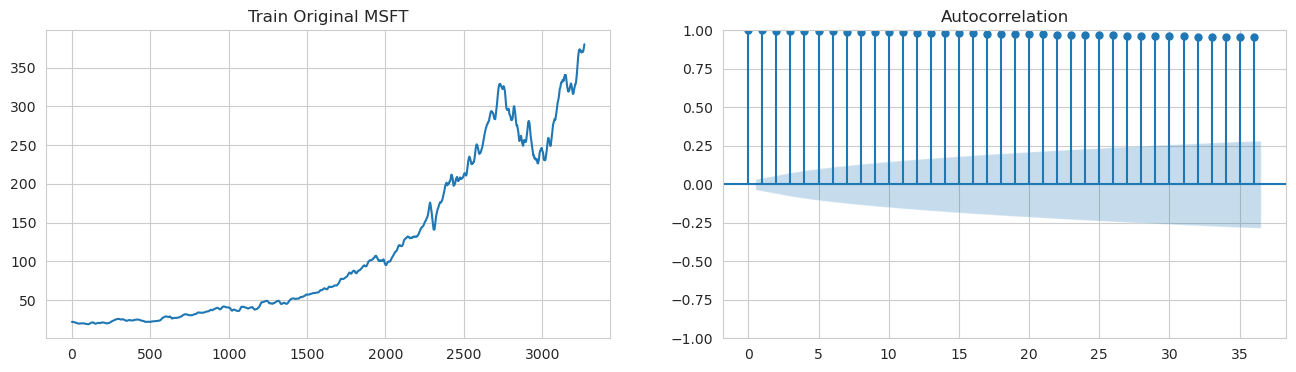

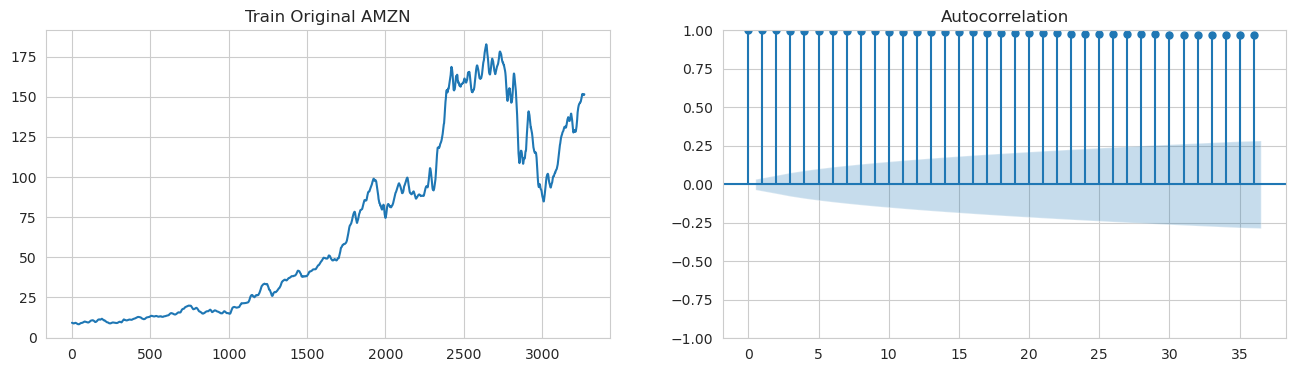

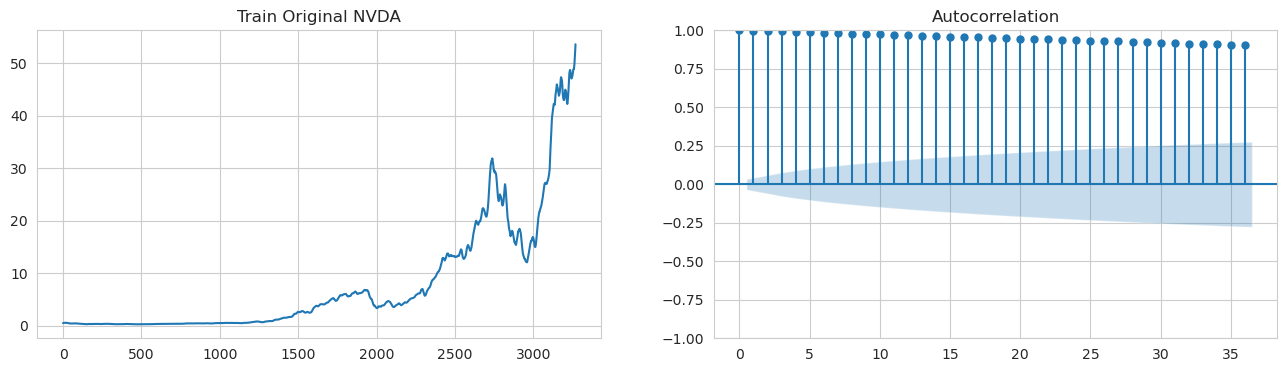

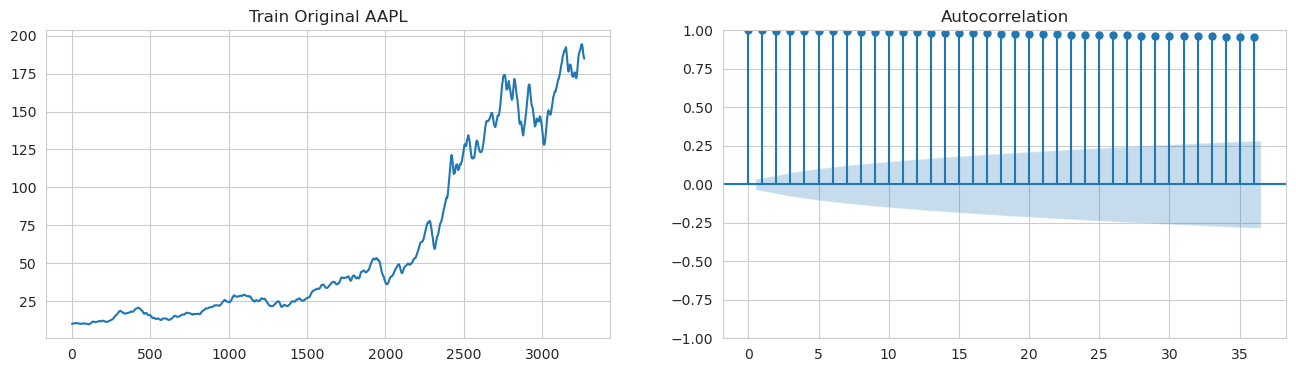

In [21]:
for i in range(len(train)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(train[i].Close)
    ax1.set_title(f"Train Original {stock_symbols[i]}")
    plot_acf(train[i].Close, ax=ax2);

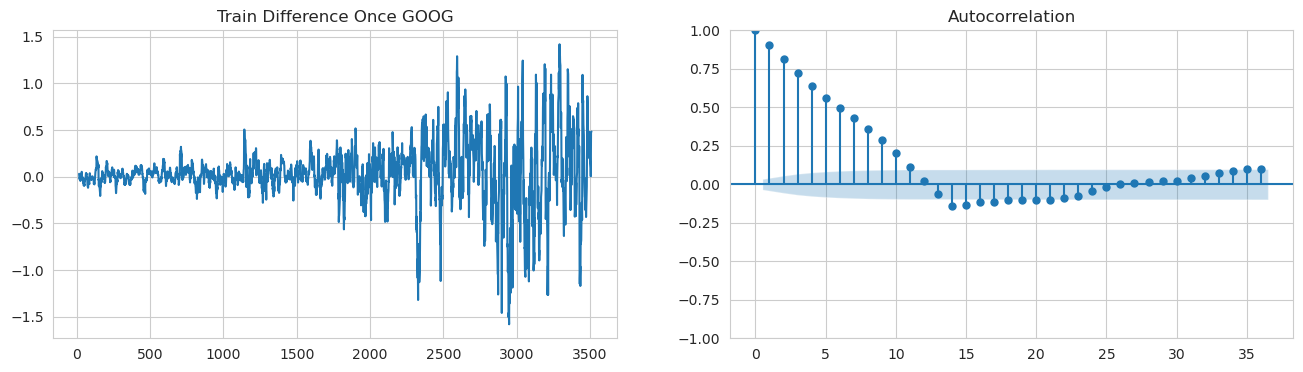

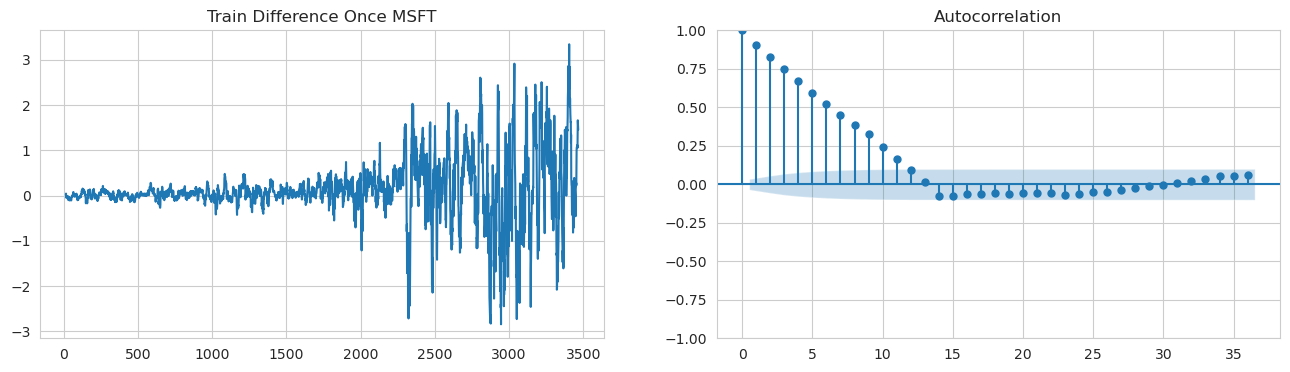

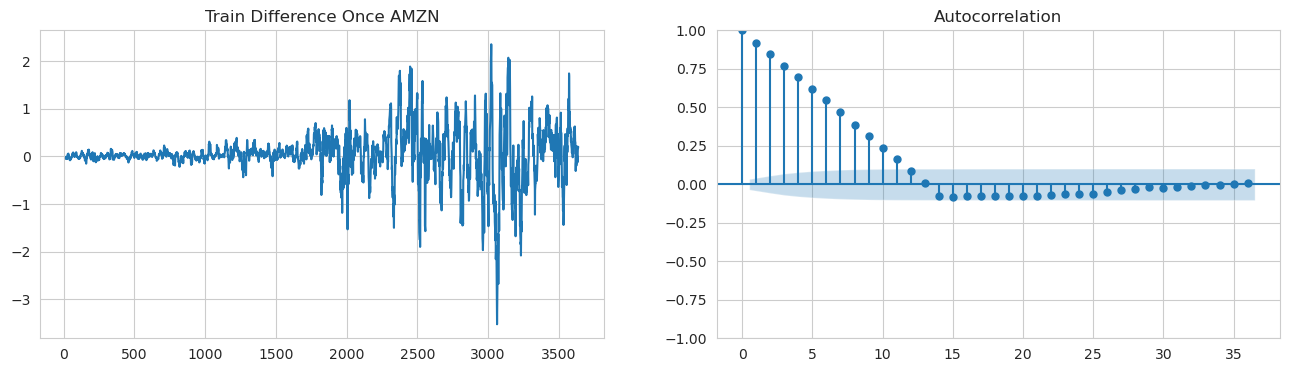

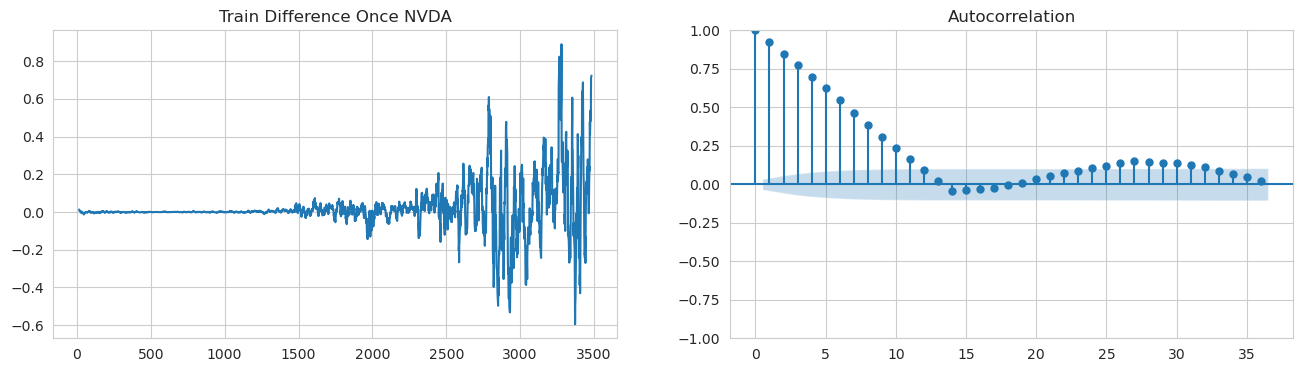

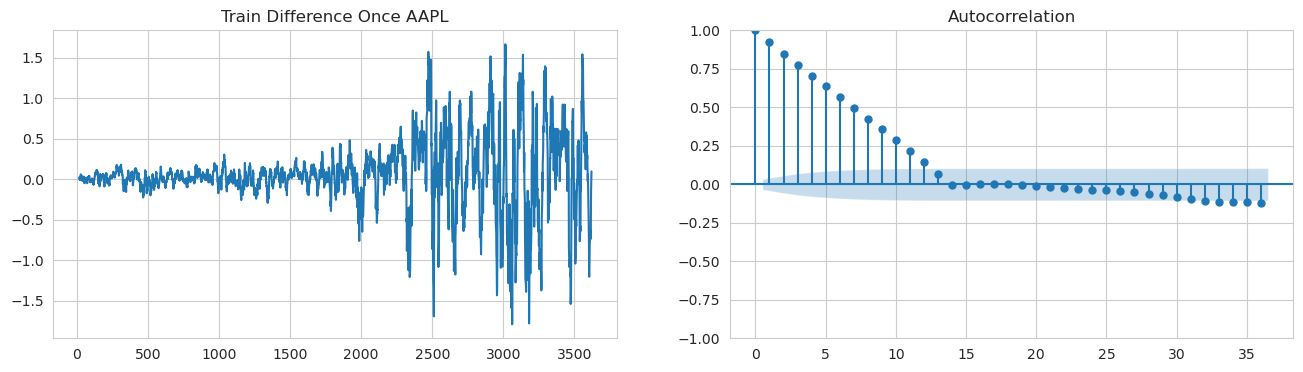

In [21]:
for i in range(len(train)):
    diff1 = train[i].Close.diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Train Difference Once {stock_symbols[i]}")
    plot_acf(diff1, ax=ax2);

In [22]:
ndif_train = [ndiffs(train[i].Close, test="adf") for i in range(len(df))]
print("ndif_train", ndif_train)

ndif_train [1, 1, 1, 1, 1]


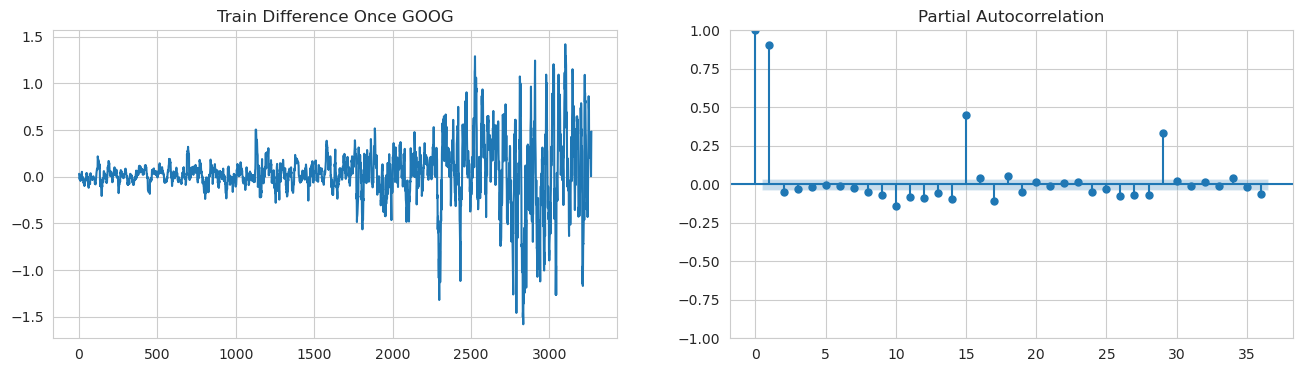

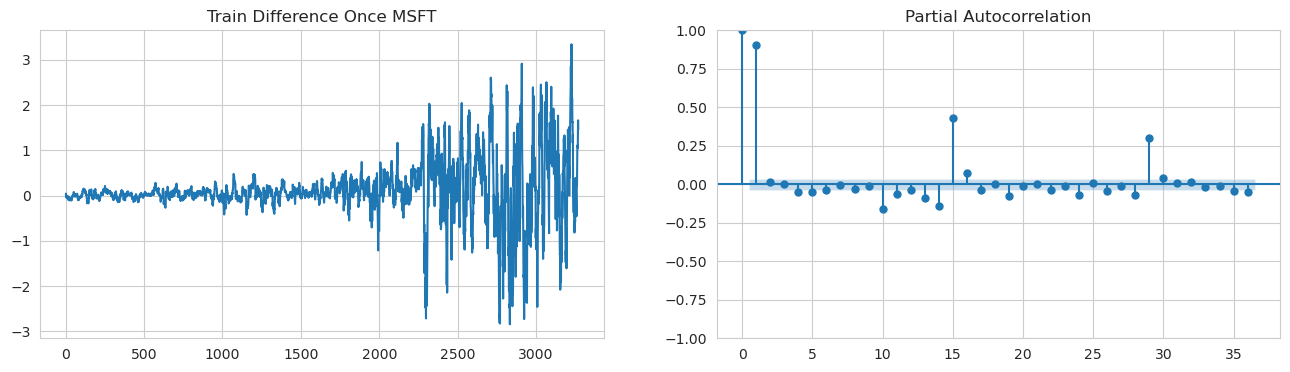

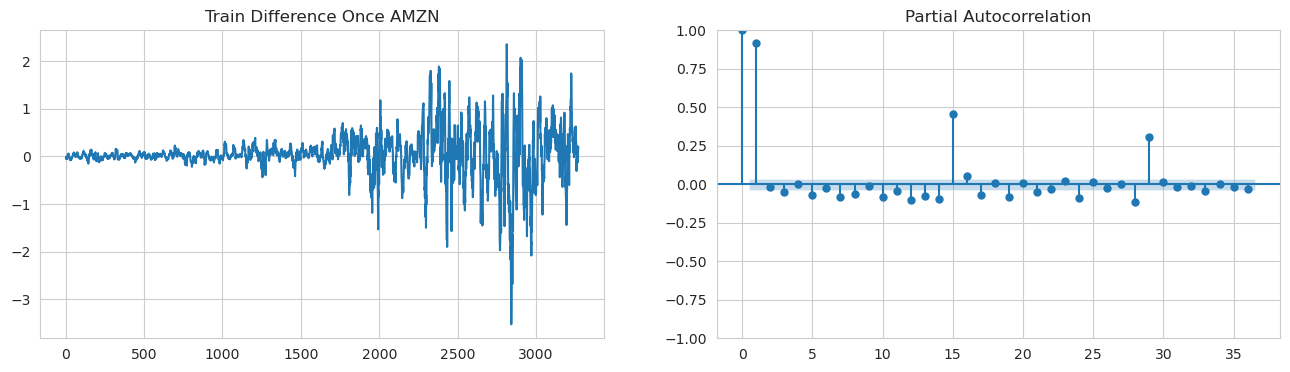

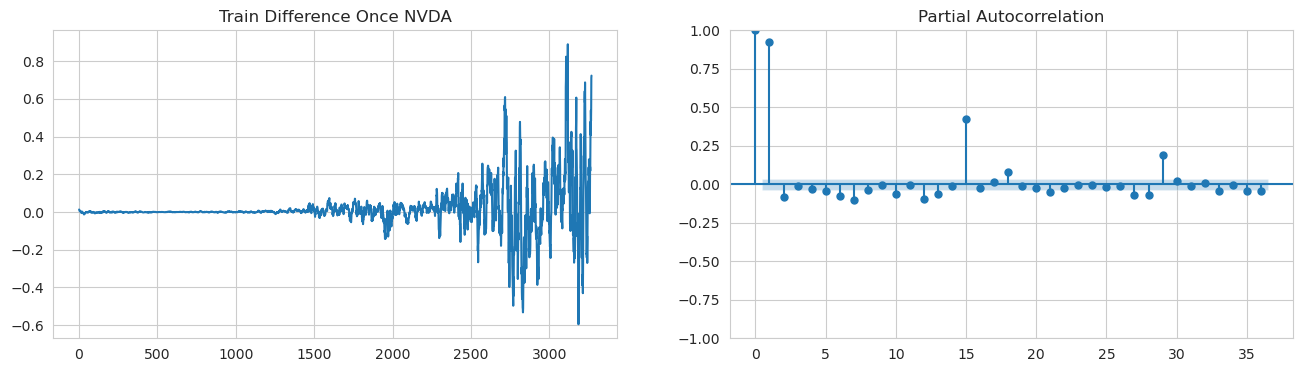

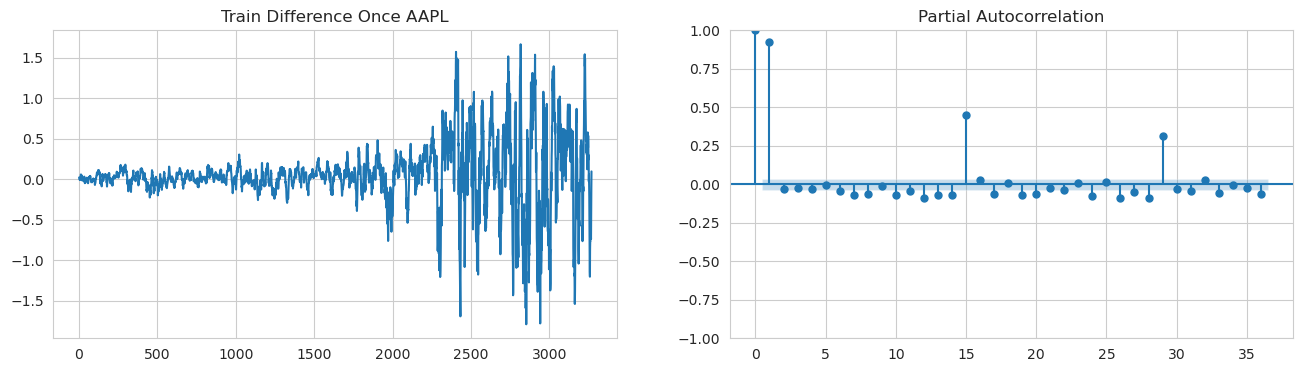

In [23]:
for i in range(len(train)):
    diff1 = train[i].Close.diff().dropna() 
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Train Difference Once {stock_symbols[i]}")
    plot_pacf(diff1, ax=ax2);

In [21]:
arima_model_train = {}
arima_order_train = {}
for i in range(len(train)):
    print(f"Stock name: {stock_symbols[i]}")
    arima_model_train[i] = auto_arima(train[i].Close, trace=True, exogenous=train_ss[i]["weighted compound sentiment score"])
    arima_order_train[i] = arima_model_train[i].get_params().get("order")
    print(f"Training Set ARIMA Order for {stock_symbols[i]}: {arima_order_train[i]}")

Stock name: GOOG
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4240.062, Time=6.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1459.356, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4208.998, Time=1.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1332.708, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1510.905, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4216.735, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4242.094, Time=3.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4215.054, Time=0.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4215.655, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4236.390, Time=6.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4217.382, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4238.249, Time=1.65 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 32.788 seconds

In [22]:
arima_result_train = {}
for i in range(len(train)):
    model_train = sm.ARIMA(train[i].Close, order=arima_order_train[i])
    arima_result_train[i] = model_train.fit()
    print(f"\n Training Set ARIMA Results for {stock_symbols[i]}:\n {arima_result_train[i].summary()}")


 Training Set ARIMA Results for GOOG:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2123.125
Date:                Tue, 26 Nov 2024   AIC                          -4238.249
Time:                        20:51:27   BIC                          -4213.880
Sample:                             0   HQIC                         -4229.522
                               - 3270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8149      0.022     83.252      0.000       1.772       1.858
ar.L2         -0.8323      0.019    -43.055      0.000      -0.870      -0.794
ma.L1       

/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Training Set ARIMA Results for NVDA:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:                 ARIMA(2, 2, 2)   Log Likelihood                5739.615
Date:                Tue, 26 Nov 2024   AIC                         -11469.229
Time:                        20:51:37   BIC                         -11438.769
Sample:                             0   HQIC                        -11458.320
                               - 3270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5818      0.018    -87.915      0.000      -1.617      -1.547
ar.L2         -0.8104      0.018    -44.088      0.000      -0.846      -0.774
ma.L1       

In [23]:
step_30=[30 for i in range(len(df))]
step=[len(test[i]) for i in range(len(df))]
step_30, step

([30, 30, 30, 30, 30], [173, 173, 173, 173, 173])

In [26]:
conf_int_30 = {}
fc_30 = {}
lower_30 = {}
upper_30 = {}
for i in range(len(df)):
    conf_int_30[i] = arima_result_train[i].get_forecast(step_30[i], exog= test_ss[i][:step_30[i]]["weighted compound sentiment score"]).conf_int(alpha=0.32)
    fc_30[i] = pd.Series(arima_result_train[i].get_forecast(step_30[i], exog= test_ss[i][:step_30[i]]["weighted compound sentiment score"]).predicted_mean, index = test[i][:step[i]].index)
    # fc_30[i] = pd.Series(arima_result_train[i].predict(step_30[i]), index = test[i][:step_30[i]].index)
    lower_30[i] = pd.Series(conf_int_30[i]['lower Close'], index = test[i][:step_30[i]].index)
    upper_30[i] = pd.Series(conf_int_30[i]['upper Close'], index = test[i][:step_30[i]].index)
    # print(conf_int_30[i])

In [27]:
conf_int = {}
fc = {}
lower = {}
upper = {}
for i in range(len(df)):
    conf_int[i] = arima_result_train[i].get_forecast(step[i], exog= test_ss[i]["weighted compound sentiment score"]).conf_int(alpha=0.32)
    fc[i] = pd.Series(arima_result_train[i].get_forecast(step[i], exog= test_ss[i]["weighted compound sentiment score"]).predicted_mean, index = test[i][:step[i]].index)
    lower[i] = pd.Series(conf_int[i]['lower Close'], index = test[i][:step[i]].index)
    upper[i] = pd.Series(conf_int[i]['upper Close'], index = test[i][:step[i]].index)
    # print(conf_int[i])

In [28]:
arima_result_train[0].get_forecast(10, exog= test_ss[i]["weighted compound sentiment score"]).conf_int(alpha=0.32)

,lower Close,upper Close
3270,142.659038,142.910330
3271,142.897036,143.446996
3272,143.063169,143.962665
3273,143.166689,144.451739
3274,143.215389,144.911028
3275,143.216200,145.338905
3276,143.175456,145.734842
3277,143.099004,146.099106
3278,142.992249,146.432559
3279,142.860177,146.736501


In [43]:
test_ss[0]

,index,weighted compound sentiment score
3270,3512,0.144400
3271,3513,0.175600
3272,3514,0.435154
3273,3515,-0.458800
3274,3516,-0.159267
...,...,...
3438,3744,0.442796
3439,3745,0.434495
3440,3746,-0.162535
3441,3747,-0.158908


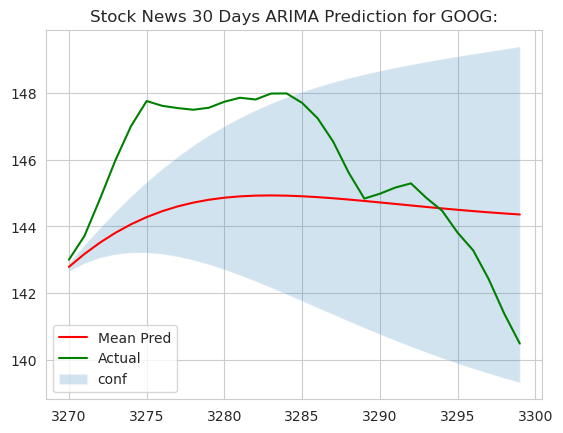

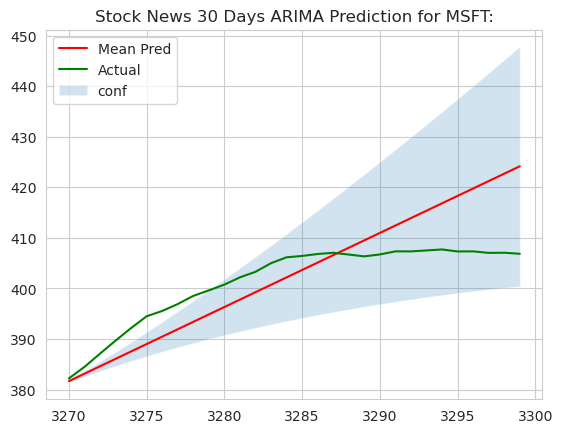

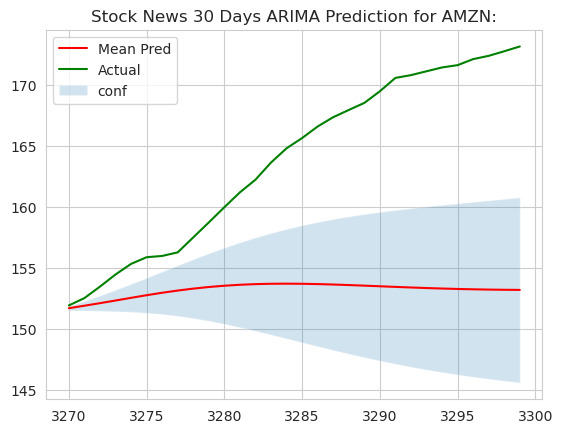

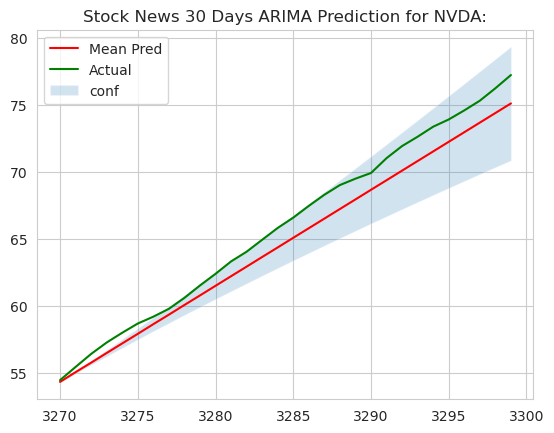

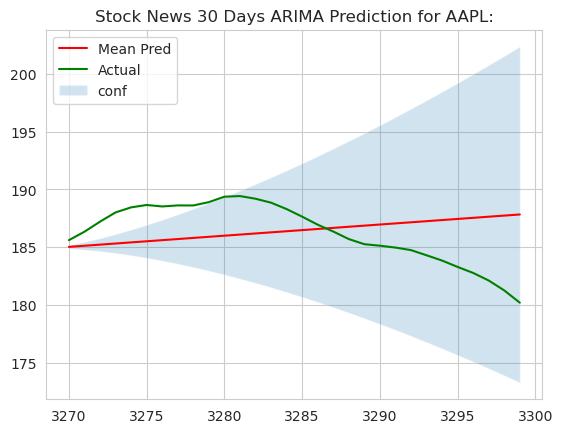

In [29]:
for i in range(len(df)):
    # plt.plot(arima_result_train[i].forecast(step_30[i]), color='r', label='Mean Pred')
    plt.plot(arima_result_train[i].get_forecast(step_30[i], exog= test_ss[i]["weighted compound sentiment score"]).predicted_mean, color='r', label='Mean Pred')
    plt.plot(test[i][:step_30[i]].Close, color='g', label='Actual')
    plt.fill_between(lower_30[i].index, lower_30[i], upper_30[i], alpha = 0.2, label='conf')
    plt.legend()
    plt.title(f"Stock News 30 Days ARIMA Prediction for {stock_symbols[i]}:")
    plt.show()

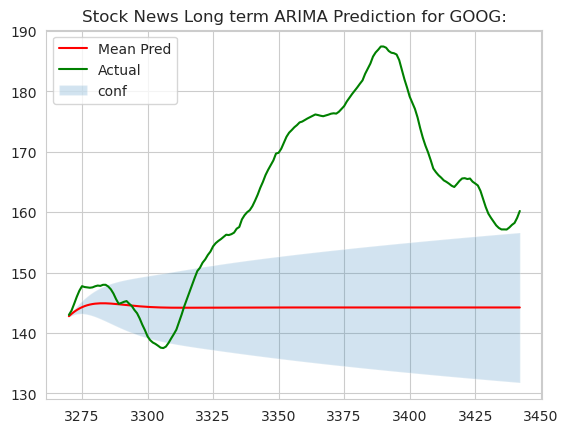

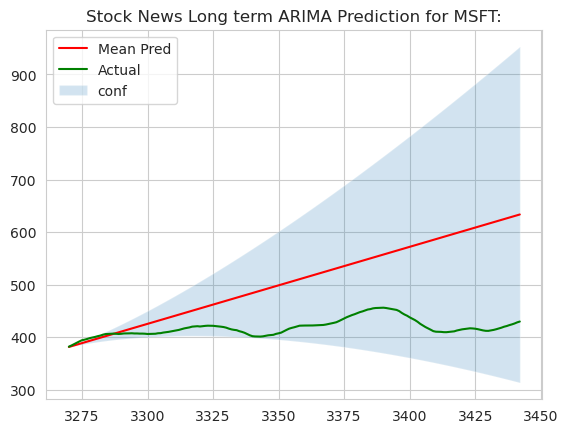

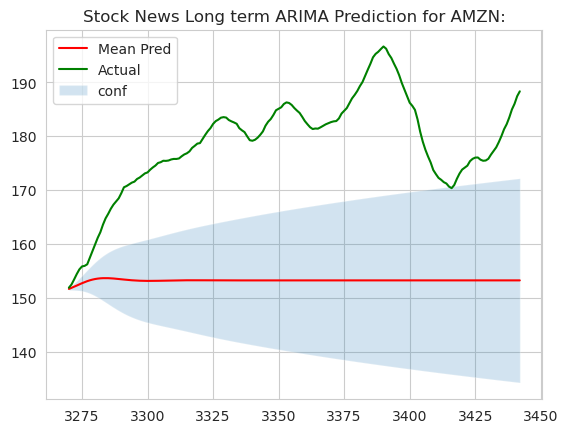

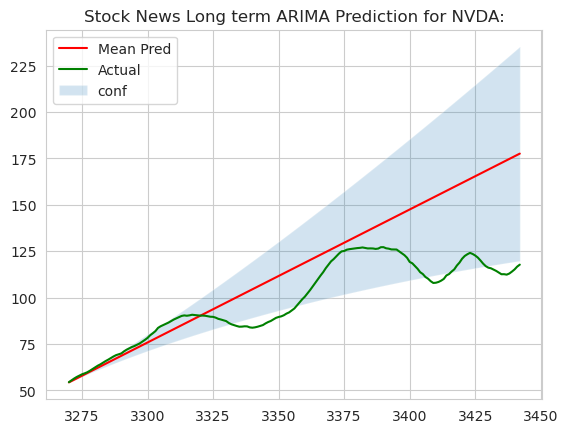

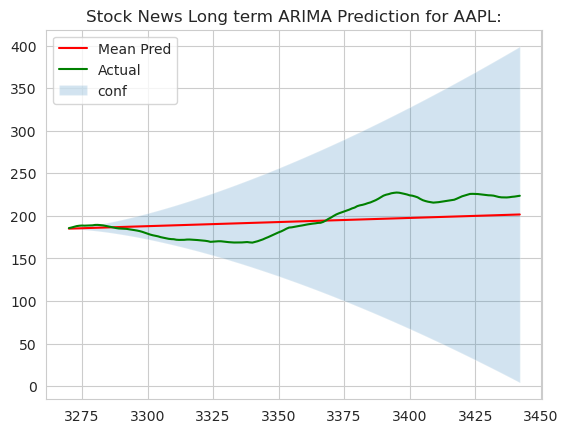

In [30]:
for i in range(len(df)):
    plt.plot(arima_result_train[i].get_forecast(step[i], exog= test_ss[i]["weighted compound sentiment score"]).predicted_mean, color='r', label='Mean Pred')
    plt.plot(test[i][:step[i]].Close, color='g', label='Actual')
    plt.fill_between(lower[i].index, lower[i], upper[i], alpha = 0.2, label='conf')
    plt.legend()
    plt.title(f"Stock News Long term ARIMA Prediction for {stock_symbols[i]}:")
    plt.show()

In [31]:
df_ARIMA_diff_30 = [((test[i][:step_30[i]].Close - fc[i][:step_30[i]]))/(test[i][:step_30[i]].Close) for i in range(len(df))]
df_ARIMA_diff = [((test[i][:step[i]].Close - fc[i][:step[i]]))/(test[i][:step[i]].Close) for i in range(len(df))]

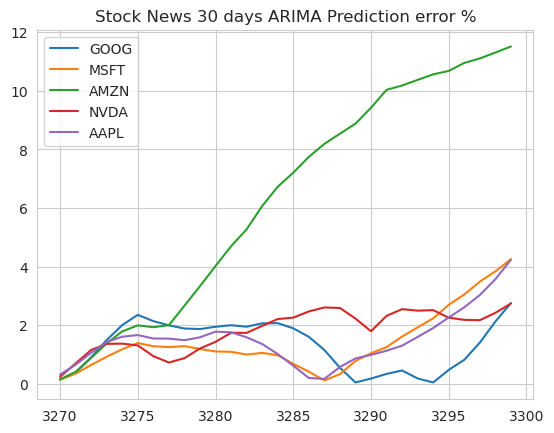

In [32]:
for i in range(len(df)):
    plt.plot(np.abs(df_ARIMA_diff_30[i]*100), label={stock_symbols[i]})
plt.title(f"Stock News 30 days ARIMA Prediction error %" , fontsize = 12)
plt.legend()

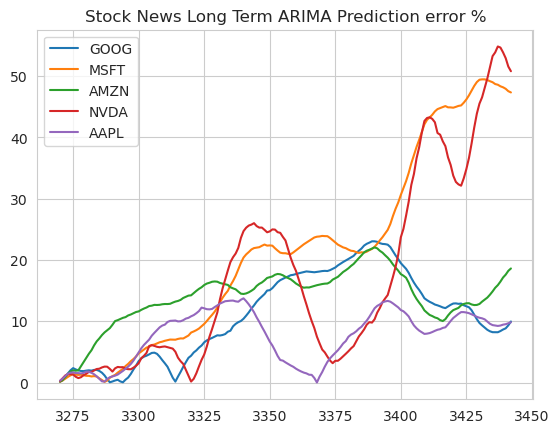

In [33]:
for i in range(len(df)):
    plt.plot(np.abs(df_ARIMA_diff[i]*100), label={stock_symbols[i]})
plt.title(f"Stock News Long Term ARIMA Prediction error %" , fontsize = 12)
plt.legend()

In [122]:
arima_result_train = {}
for i in range(len(train)):
    model_train = SARIMAX(train[i].Close, order=arima_order_train[i], exog = train_ss[i]["weighted compound sentiment score"])
    arima_result_train[i] = model_train.fit()
    print(f"\n Training Set ARIMA Results for {stock_symbols[i]}:\n {arima_result_train[i].summary()}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.46195D-01    |proj g|=  1.59089D-01


 This problem is unconstrained.



At iterate    5    f= -6.47139D-01    |proj g|=  1.04876D-02

At iterate   10    f= -6.47307D-01    |proj g|=  8.82238D-03

At iterate   15    f= -6.47327D-01    |proj g|=  6.99907D-03

At iterate   20    f= -6.49185D-01    |proj g|=  1.03903D-01

At iterate   25    f= -6.49338D-01    |proj g|=  8.75934D-03

At iterate   30    f= -6.49345D-01    |proj g|=  5.64347D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   5.486D-05  -6.493D-01
  F = -0.64934513964165275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Training Set ARIMA Results for GOOG:
            

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     11      1     0     0   3.500D-05   1.090D-01
  F =  0.10900784621319205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Training Set ARIMA Results for MSFT:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -356.456
Date:                Sun, 17 Nov 2024   AIC                            720.911
Time:                        23:35:08   BIC                        

 This problem is unconstrained.



At iterate    5    f= -2.73756D-01    |proj g|=  1.48656D-01

At iterate   10    f= -2.74931D-01    |proj g|=  4.39593D-02

At iterate   15    f= -2.80224D-01    |proj g|=  7.13624D-02

At iterate   20    f= -2.82160D-01    |proj g|=  1.35074D-02

At iterate   25    f= -2.82449D-01    |proj g|=  2.20359D-03

At iterate   30    f= -2.82496D-01    |proj g|=  2.13686D-02

At iterate   35    f= -2.82743D-01    |proj g|=  3.91343D-03

At iterate   40    f= -2.82751D-01    |proj g|=  8.06744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     48      1     0     0   1.284D-04  -2.828D-01
  F = -0.282751157755

 This problem is unconstrained.



At iterate    5    f= -1.74746D+00    |proj g|=  2.66295D-01

At iterate   10    f= -1.74830D+00    |proj g|=  2.04440D-03

At iterate   15    f= -1.74831D+00    |proj g|=  3.57647D-03

At iterate   20    f= -1.74831D+00    |proj g|=  1.21584D-02

At iterate   25    f= -1.74862D+00    |proj g|=  1.75777D-01

At iterate   30    f= -1.74906D+00    |proj g|=  1.20722D-01

At iterate   35    f= -1.74908D+00    |proj g|=  1.38401D-02

At iterate   40    f= -1.74945D+00    |proj g|=  3.34327D-01

At iterate   45    f= -1.75552D+00    |proj g|=  6.77950D-01


/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -1.76058D+00    |proj g|=  2.40632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.406D-02  -1.761D+00
  F =  -1.7605834537175216     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 Training Set ARIMA Results for NVDA:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:               SARIMAX(2, 2, 2)   Log Likelihood                5757.108
Date:                Sun, 17 Nov 2024   AIC                         -11502.216
Time:


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     63      2     0     0   2.849D-04  -4.757D-01
  F = -0.47573674799358773     

ABNORMAL_TERMINATION_IN_LNSRCH                              

 Training Set ARIMA Results for AAPL:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:               SARIMAX(0, 2, 0)   Log Likelihood                1555.659
Date:                Sun, 17 Nov 2024   AIC                          -3107.318
Time:                        23:35:25   BIC                        

/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
